This script uses a training set of x-rays for C19 negative patients. The images are used to train up an autoencoder which attempts to encode and then reconstruct the input. The aim is to present it with a test set comprising a mixture of C19 positive and negative images. If the trained autoencoder generally has a higher reconstruction error on the C19 positive images, it will be essentially flagging these as anomalous and differentiating them from the negative images.

## Importing libraries and defining global variables

In [1]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,Reshape,LeakyReLU
from keras.models import Model
from matplotlib import pyplot as plt
import numpy as np
import random
import os
from keras.callbacks import TensorBoard

BATCH_SIZE=16
LEARNING_RATE=0.0001
NUM_EPOCHS=20
MAIN_ACTIVATION_FN = LeakyReLU()
X_SIZE=256#236#124
Y_SIZE=256#188#92
SRC_DIR="C:\\Users\\ahall\\Documents\\datasets\\covid19-radiography-database\\COVID-19 Radiography Database"

Using TensorFlow backend.
C:\Users\ahall\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ahall\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ahall\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

## Creating an input stream
This function uses the keras data generator method to build a stream of input images from a folder of raw images. Additional preprocessing may be added at a later stage.

It will probably be necessary to test with a 'test positive' and 'test_negative' set so we can see whether the autoencoder differentiates between positive and negative x-rays.


In [2]:
def build_data_generator(phase,x_size,y_size,batch_size,shf):
    datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
    directory=os.path.join(SRC_DIR,phase),
    target_size=(y_size, x_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="input",
    shuffle=shf,
    seed=42)
    
    return data_generator

train_generator = build_data_generator("train_negative",X_SIZE,Y_SIZE,BATCH_SIZE,True)
test_positive_generator = build_data_generator("test_positive",X_SIZE,Y_SIZE,1,False)
test_negative_generator = build_data_generator("test_negative",X_SIZE,Y_SIZE,1,False)


Found 1236 images belonging to 1 classes.
Found 219 images belonging to 1 classes.
Found 105 images belonging to 1 classes.


## Building the autoencoder
Here the architecture of the autoencoder is defined. We start with the input image and through repeated convolutional layers and pooling layers, we transform it into a one-dimensional vector. This is fed into a number of fully connected hidden layers before being reconstructed into the 'decoded' image at the end. A perfect autoencoder would take the input and be able to reconstruct it with 100% accuracy. Ours will be trained to reconstruct covid-negative images. So, if covid-positive images have unique features that can be sufficiently distinguished, it will not be ableto reconstruct them as accurately as the negative images.

In [3]:
input_img = Input(shape=(Y_SIZE, X_SIZE, 1))

x = Conv2D(2, (2, 2), padding='same')(input_img)
x=MAIN_ACTIVATION_FN(x)
x = Conv2D(4, (2, 2), padding='same')(input_img)
x=MAIN_ACTIVATION_FN(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (2, 2), padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x = Conv2D(16, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x= MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (2, 2), padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x= MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (2, 2), padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x= MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
#x = Conv2D(256, (2, 2), activation='relu', padding='same')(x)
x= MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
#x = Conv2D(512, (2, 2), activation='relu', padding='same')(x)
x= MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(2048, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
#x = Conv2D(2048, (2, 2), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2))(x) 
encoded = Flatten()(encoded)

#the representation is now 1x1x2048

#fully connected layer
x=Dense(2048)(encoded)
x=Reshape((1,1,2048))(x)



x = Conv2D(2048, (2, 2), padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
#x = Conv2D(2048, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
#x = Conv2D(512, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
#x = Conv2D(256, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (2, 2),  padding='same')(x) 
x=MAIN_ACTIVATION_FN(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x = Conv2D(16, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x = Conv2D(4, (2, 2),  padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(2, (2, 2), padding='same')(x)
x=MAIN_ACTIVATION_FN(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

opt =keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt=keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#opt=keras.optimizers.SGD(lr=LEARNING_RATE, momentum=0.0, decay=0.05, nesterov=False)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img,encoded)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


## Training the autoencoder
Here we introduce the training set of covid negative images to the autoencoder network. The training process should create a network able to reconstruct its input with reasonable accuracy. 

In [4]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_NEGATIVE_TEST=test_negative_generator.n//test_negative_generator.batch_size
STEP_SIZE_POSITIVE_TEST=test_positive_generator.n//test_positive_generator.batch_size

In [13]:


autoencoder.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_negative_generator,
                    validation_steps=STEP_SIZE_NEGATIVE_TEST,
                    epochs=NUM_EPOCHS,
                    callbacks=[TensorBoard(log_dir='C:\\Users\\ahall\\Documents\\projects\\c19-anomaly-detection\\tensorboard_logs')]
)

autoencoder.save ("flattening_autoencoder.h5")

Epoch 1/20
77/77 [==============================] - 328s 4s/step - loss: 0.6544 - val_loss: 0.6236
Epoch 2/20
77/77 [==============================] - 261s 3s/step - loss: 0.6193 - val_loss: 0.6188
Epoch 3/20
77/77 [==============================] - 265s 3s/step - loss: 0.6135 - val_loss: 0.6125
Epoch 4/20
77/77 [==============================] - 289s 4s/step - loss: 0.6096 - val_loss: 0.6071
Epoch 5/20
77/77 [==============================] - 356s 5s/step - loss: 0.6046 - val_loss: 0.6027
Epoch 6/20
77/77 [==============================] - 264s 3s/step - loss: 0.5998 - val_loss: 0.5996
Epoch 7/20
77/77 [==============================] - 260s 3s/step - loss: 0.5965 - val_loss: 0.5977
Epoch 8/20
77/77 [==============================] - 260s 3s/step - loss: 0.5970 - val_loss: 0.5965
Epoch 9/20
77/77 [==============================] - 259s 3s/step - loss: 0.5951 - val_loss: 0.5966
Epoch 10/20
77/77 [==============================] - 274s 4s/step - loss: 0.5941 - val_loss: 0.5945
Epoch 11/

## Testing the autoencoder
Here we allow the autoencoder to encode and reconstruct test set images. We feed a test set of covid positive images and measure the RMSE between the input and reconstructed images. We hope to see a higher MSE for the covid positive images.

The current method of iterating over the predictions and calculating MSE is not particularly efficient, it was necessitated by the fact that the prediction method introduces extra dimensions to the result. This section could therefor ebe cleaned up if we get the time.

In [6]:
autoencoder = keras.models.load_model('flattening_autoencoder.h5')
positive_predictions = autoencoder.predict_generator(generator=test_positive_generator, steps=STEP_SIZE_POSITIVE_TEST)
negative_predictions = autoencoder.predict_generator(generator=test_negative_generator, steps=STEP_SIZE_NEGATIVE_TEST)


Instructions for updating:
Use tf.cast instead.


In [7]:
import cv2 
positive_mse_list = []
negative_mse_list = []

#refactor these later
for i in range(len(test_positive_generator)):
    p_mse = (np.square(test_positive_generator[i][0][0] - positive_predictions[i])).mean(axis=None)
    positive_mse_list.append(p_mse)

for i in range(len(test_negative_generator)):
    n_mse = (np.square(test_negative_generator[i][0][0] - negative_predictions[i])).mean(axis=None)
    negative_mse_list.append(n_mse)



## Plotting the results
These plots do seem to show some distinction between the positive and negative cases, however it is far too early to draw conclusions. For this trial dataset, there were twice as many positive test cases so we may be seeing the effect of more outliers. Further statistical validation will be necessary, with a far larger dataset.

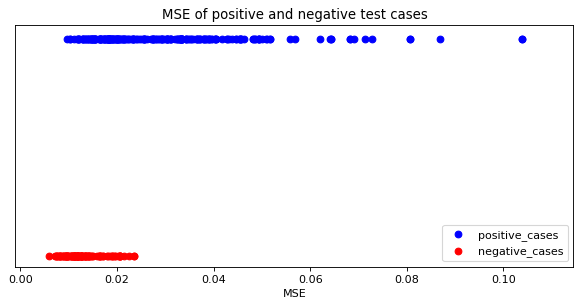

In [13]:
%matplotlib inline

fig=plt.figure(figsize=(9, 4), dpi= 80, facecolor='w', edgecolor='k')
pos=plt.scatter(positive_mse_list, np.ones_like(positive_mse_list), c='b')
neg=plt.scatter(negative_mse_list, np.zeros_like(negative_mse_list), c='r')
plt.legend((pos,neg),("positive_cases","negative_cases"))
plt.title("MSE of positive and negative test cases")
plt.xlabel("MSE")
plt.yticks([])
plt.show()


Again, a density plot does seem to show a difference in MSE between positive and negative cases, but more work will be necessary to determine if this is statistically significant.

Text(0, 0.5, 'KDE')

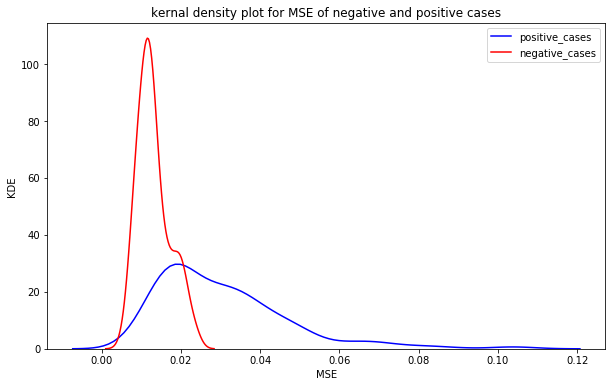

In [41]:
import seaborn as sn
f, ax = plt.subplots(figsize=(10,6))
ax = sn.kdeplot(positive_mse_list, label="positive_cases", color='b', legend = True)
ax = sn.kdeplot(negative_mse_list, label="negative_cases", color='r', legend = True).set_title("kernal density plot for MSE of negative and positive cases")
plt.xlabel("MSE")
plt.ylabel("KDE")

## Plotting some example images
Here we plot raw images, and then the reconstructed images after they have been fed through the autoencoder. This allows us to visually see how the autoencoder attempts to reeconstruct the images. It seems to do a reasonable job for now (although that doesn't necessarily matter - what matters is that is systematically reconstructs C19 positive and negative images differently)

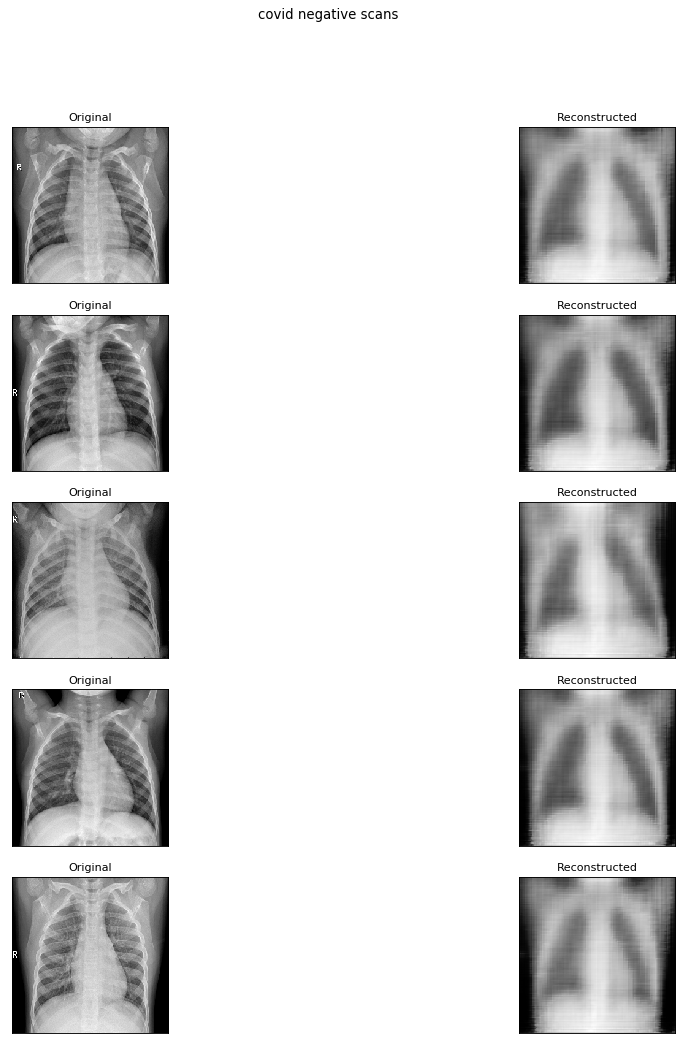

In [74]:
import random



def plot_examples(originals, predictions, title):
    fig=plt.figure(figsize=(15, 15), dpi= 80)
    fig.suptitle(title)
    for i in range(5):
        example = random.randint(0,len(predictions)-1)

        ax = plt.subplot(5, 2, (2*i)+1)
        plt.imshow(np.squeeze(originals[example][0][0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Original" , fontsize=10)

        #display encoded image
        ax = plt.subplot(5, 2, 2*i +2)
        plt_img = predictions[example]
        grey=np.squeeze(predictions[example]*255)
        plt.imshow(grey)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Reconstructed" , fontsize=10)
        i=i+1
        
plot_examples(test_negative_generator, negative_predictions, "covid negative scans - original and reconstructed")

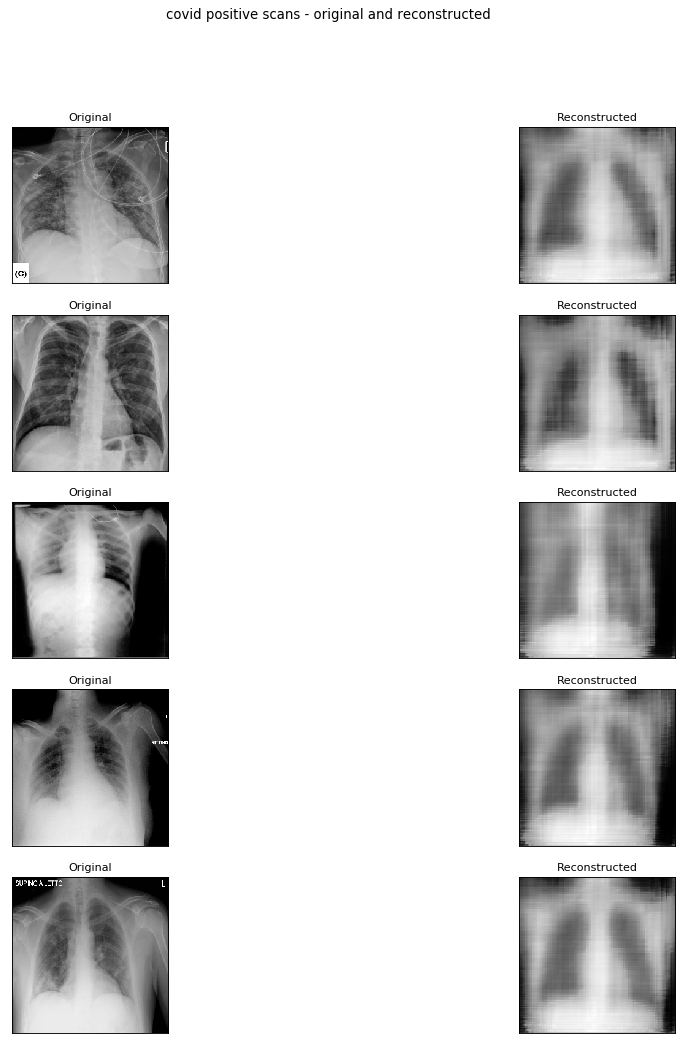

In [75]:
plot_examples(test_positive_generator, positive_predictions, "covid positive scans - original and reconstructed")